<a href="https://colab.research.google.com/github/TITHI007/NLP/blob/main/NLP_Practical_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implement text processing with neural network**

In [ ]:
!pip install tensorflow
!pip install tensorflow_datasets

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

encoded_example = encoder(example)[:3].numpy()
encoded_example

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRZPPCD/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRZPPCD/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRZPPCD/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
texts:  [b"This should be required viewing for all young people. This is documentary at its best, from the haunting music and 

array([[ 11, 139,  28, ...,   0,   0,   0],
       [243,   9,  14, ...,   0,   0,   0],
       [370,  72,  69, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

print([layer.supports_masking for layer in model.layers])

# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0]) 

Original:  b"This should be required viewing for all young people. This is documentary at its best, from the haunting music and terrific narration by Olivier to its unflinching and penetrating analyses, The World at War is unforgettable and irreplaceable for anyone who wants to know about humanity's sorry experience at the nadir of the 20th century."
Round-trip:  this should be [UNK] viewing for all young people this is documentary at its best from the [UNK] music and [UNK] [UNK] by [UNK] to its [UNK] and [UNK] [UNK] the world at war is [UNK] and [UNK] for anyone who wants to know about [UNK] sorry experience at the [UNK] of the [UNK] [UNK]                                                                                                                                                                                                                                                                                                                                                                

Epoch 1/3
391/391 [==============================] - 744s 2s/step - loss: 0.6530 - accuracy: 0.5586 - val_loss: 0.5209 - val_accuracy: 0.7214
Epoch 2/3
391/391 [==============================] - 723s 2s/step - loss: 0.4195 - accuracy: 0.8052 - val_loss: 0.3993 - val_accuracy: 0.8432
Epoch 3/3
391/391 [==============================] - 154s 395ms/step - loss: 0.3495 - accuracy: 0.8568
Test Loss: 0.3495103418827057
Test Accuracy: 0.8568000197410583
Epoch 1/10
391/391 [==============================] - 1410s 4s/step - loss: 0.6276 - accuracy: 0.5804 - val_loss: 0.4386 - val_accuracy: 0.8130
Epoch 2/10
391/391 [==============================] - 1371s 4s/step - loss: 0.3789 - accuracy: 0.8350 - val_loss: 0.3655 - val_accuracy: 0.8255
Epoch 3/10
391/391 [==============================] - 1388s 4s/step - loss: 0.3340 - accuracy: 0.8574 - val_loss: 0.3264 - val_accuracy: 0.8510
Epoch 4/10
391/391 [==============================] - 1382s 4s/step - loss: 0.3186 - accuracy: 0.8648 - val_loss: 0.3

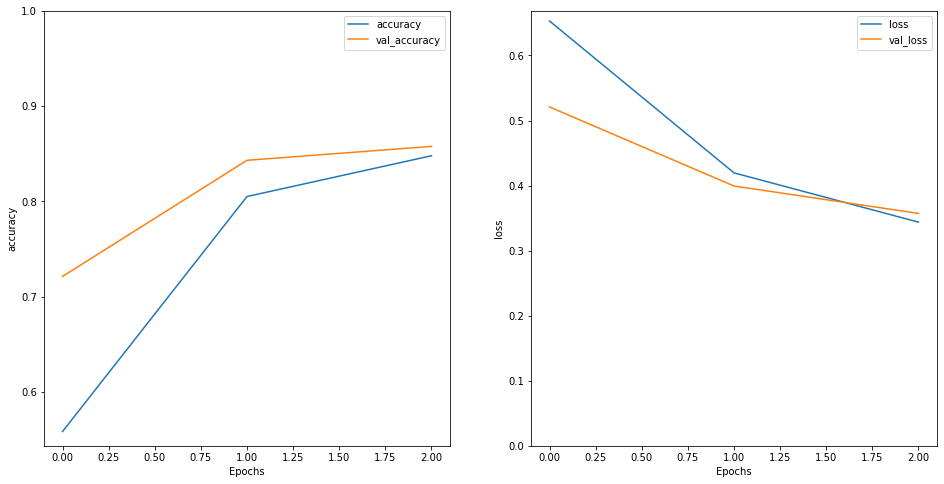

In [6]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=3,
                    validation_data=test_dataset,
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

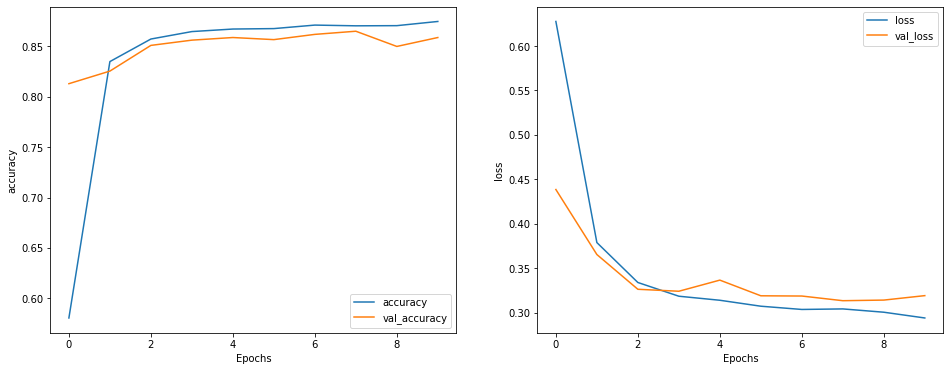

In [7]:
5/plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
pl
\t.subplot(1, 2, 2)
plot_graphs(history, 'loss')